In [1]:
import time
import numpy as np
import pandas as pd
import joblib as jl

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.inspection import DecisionBoundaryDisplay

In [2]:
names = [ 'Nearest Neighbors'
        , 'Linear SVM'
        , 'RBF SVM'
        , 'Gaussian Process'
        , 'Decision Tree'
        , 'Random Forest'
        , 'Neural Net'
        , 'AdaBoost'
        , 'Naive Bayes'
        , 'QDA' ]

In [3]:
classifiers = [ KNeighborsClassifier(3)
              , SVC(kernel='linear', C=0.025)
              , SVC(gamma=2, C=1)
              , GaussianProcessClassifier(1.0 * RBF(1.0))
              , DecisionTreeClassifier(max_depth=5)
              , RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
              , MLPClassifier(alpha=1, max_iter=1000)
              , AdaBoostClassifier()
              , GaussianNB()
              , QuadraticDiscriminantAnalysis() ]

In [4]:
data = pd.read_csv('../data/classData.csv')

In [5]:
data['FM'] = np.sum(data[['G','C','B','A']].values * np.array([[2 ** e for e in range(4)]]), axis = 1)
data['FB'] = (np.sum(data[['G','C','B','A']].values, axis = 1) >= 1).astype(float)

In [6]:
x_keys = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
y_keys = ['G','C','B','A']

X = data[x_keys].values
y = np.squeeze(data['FB'].values)

In [11]:
X_scale = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X_scale, y
                                                   , test_size    = 0.3
                                                   , random_state = 666
                                                   , )

In [108]:
h = .1

xx, yy = np.meshgrid( np.arange(x_min, x_max, h)
                    , np.arange(y_min, y_max, h)
                    , )


x__ = np.c_[xx.ravel(), yy.ravel()]
x_  = np.concatenate((x__,np.repeat(X_scale[666,2:6][None], x__.shape[0], axis = 0)), axis = 1)

In [109]:
def fit_clf(name, clf, train_x, train_y, test_x, test_y):
    print(f'Fitting {name} ...')
    tic = time.time()
    clf.fit(train_x, train_y)
    toc = time.time()
    print(f'\tTook: {(toc - tic):.3}s')
    score = clf.score(test_x, test_y)
    print(f'\tScore: {score:.3}')
    return clf

In [51]:
clf_fit = { name: fit_clf(name, clf, X_train, y_train, X_test, y_test)
            for name, clf in zip(names, classifiers) }

Fitting Nearest Neighbors ...
	Took: 0.00706s
	Score: 1.0
Fitting Linear SVM ...
	Took: 0.502s
	Score: 0.697
Fitting RBF SVM ...
	Took: 0.153s
	Score: 0.998
Fitting Gaussian Process ...


/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


	Took: 3.4e+02s
	Score: 1.0
Fitting Decision Tree ...
	Took: 0.00839s
	Score: 0.989
Fitting Random Forest ...
	Took: 0.0222s
	Score: 0.997
Fitting Neural Net ...
	Took: 1.14s
	Score: 0.974
Fitting AdaBoost ...
	Took: 0.214s
	Score: 1.0
Fitting Naive Bayes ...
	Took: 0.00119s
	Score: 0.972
Fitting QDA ...
	Took: 0.00155s
	Score: 0.993


/home/uhlmanny/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [52]:
for name, clf in clf_fit.items():
    jl.dump(clf, f'../models/{name.replace(" ", "_")}.clf')

In [110]:
def decision_boundary(clf):
    if hasattr(clf, "decision_function"):
        z = clf.decision_function(x_)
    else:
        z = clf.predict_proba(x_)[:, 1]
    
    return np.reshape(z, xx.shape)

<Figure size 432x288 with 0 Axes>

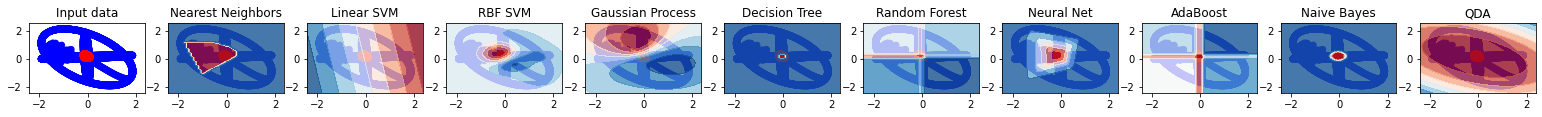

In [113]:
plt.tight_layout()
figure = plt.figure(figsize=(27, 9))
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(6, len(classifiers) + 1, 1)
ax.set_title("Input data")
ax.scatter( X_scale[:, 0], X_scale[:, 1]
          , c=y, cmap=cm_bright
          , edgecolors=None )

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

for i,(n,c) in list(enumerate(clf_fit.items())):
    ax = plt.subplot(6, len(classifiers) + 1, i + 2)
    zz = decision_boundary(c)
    
    ax.scatter( X_scale[:, 0], X_scale[:, 1]
              , c=y, cmap=cm_bright
              , edgecolors=None )
    
    ax.contourf( np.resize(xx, zz.shape), np.resize(yy, zz.shape), zz, cmap=cm, alpha=.8 )
    
    ax.set_title(f'{n}')

plt.savefig('../plots/comparison.png')

In [ ]:
def predict_m(clf, X):
    return np.unpackbits(clf.predict(X.reshape(1,-1)).astype(np.uint8))[-4:].reshape(1,-1)

def predict_b(clf, X):
    return clf.predict(X.reshape(1,-1)).reshape(1,-1)

In [ ]:
#clf_fit['QDA'].predict(x)
y_p = predict_b(clf_fit['QDA'],  d[x_keys].values)